## SRJ

In [1]:
import pennylane as qml
from pennylane import qchem
from pennylane import numpy as np
from itertools import chain
import time
import re
from scipy.optimize import minimize
ash_excitation = []
energies = []
excitations= []
grad_old=[]

X = qml.PauliX
Y = qml.PauliY
Z = qml.PauliZ
I = qml.Identity



bond_length = 3.0
symbols = ["H","H","H","H"]
electrons = 4
orbitals = 8
r_bohr = bond_length *1.8897259886  
coordinates = np.array([[0.0,0.0, 1*r_bohr], [0.0, 0.0, 2*r_bohr], [0.0,0.0,3*r_bohr],[0.0, 0.0, 4*r_bohr]])
H, qubits = qml.qchem.molecular_hamiltonian(symbols, coordinates, basis="sto-6g", method="pyscf")
hf_state = qchem.hf_state(electrons, qubits)




def adaptvqe(adapt_it = 4, e_th=1e-12):
    ash_excitation = []
    energies = []
    excitations= []
    #Calculation of HF state
    dev = qml.device("lightning.qubit", wires=qubits)
    @qml.qnode(dev)
    def circuit(hf_state, electrons, qubits, H):
        print('Updated hf_state is', hf_state)  
        qml.BasisState(hf_state, wires=range(qubits))
        return qml.expval(H)   #Calculating the expectation value of the Hamiltonian
    
    # Commutator calculation for HF state
    @qml.qnode(dev)
    def commutator_0(H,w, k):  #H is the Hamiltonian, w is the operator, k is the basis state - HF state
        qml.BasisState(k, wires=range(qubits))
        res = qml.commutator(H, w)   #Calculating the commutator
        return qml.expval(res)
    
    # Commutator calculation for other states except HF state
    @qml.qnode(dev)
    def commutator_1(H,w, k): #H is the Hamiltonian, w is the operator, k is the basis state
        qml.StatePrep(k, wires=range(qubits))
        res = qml.commutator(H, w) #Calculating the commutator
        return qml.expval(res)

    #Energy calculation 
    @qml.qnode(dev)
    def ash(params, ash_excitation, hf_state, H):
        [qml.PauliX(i) for i in np.nonzero(hf_state)[0]]  #Appln of HF state
        for i, excitation in enumerate(ash_excitation):
            if len(ash_excitation[i]) == 4:
                qml.FermionicDoubleExcitation(weight=params[i], wires1=list(range(ash_excitation[i][0], ash_excitation[i][1] + 1)), wires2=list(range(ash_excitation[i][2], ash_excitation[i][3] + 1)))
            elif len(ash_excitation[i]) == 2:
                qml.FermionicSingleExcitation(weight=params[i], wires=list(range(ash_excitation[i][0], ash_excitation[i][1] + 1)))
        return qml.expval(H)  #Calculating the expectation value of the Hamiltonian
    
    # Calculation of New state, same as the above function but with the state return
    dev1 = qml.device("lightning.qubit", wires=qubits)
    @qml.qnode(dev1)
    def new_state(hf_state, ash_excitation, params):
        [qml.PauliX(i) for i in np.nonzero(hf_state)[0]] #Applying the HF state
        for i, excitations in enumerate(ash_excitation):
            if len(ash_excitation[i]) == 4:
                qml.FermionicDoubleExcitation(weight=params[i], wires1=list(range(ash_excitation[i][0], ash_excitation[i][1] + 1)), wires2=list(range(ash_excitation[i][2], ash_excitation[i][3] + 1)))
            elif len(ash_excitation[i]) == 2:
                qml.FermionicSingleExcitation(weight=params[i], wires=list(range(ash_excitation[i][0], ash_excitation[i][1] + 1)))
        return qml.state()
    
    def cost(params):
        energy = ash(params, ash_excitation, hf_state, H)
        return energy

    def callback(params):
        print(f"Current parameters: {params}")
        print(f"Current cost: {cost(params)}\n")
    

    print('HF state is', circuit(hf_state, electrons, qubits, H))
    singles, doubles = qml.qchem.excitations(electrons, orbitals)
    op1 =  [qml.fermi.FermiWord({(0, x[0]): "+", (1, x[1]): "-"}) for x in singles]
    op2 =  [qml.fermi.FermiWord({(0, x[0]): "+", (1, x[1]): "+", (2, x[2]): "-", (3, x[3]): "-"})for x in doubles]
    operator_pool = (op1) + (op2)  #Operator pool - Singles and Doubles
    states = [hf_state]
    

    for j in range(adapt_it):
        print('The adapt iteration now is', j)  #Adapt iteration
        max_value = float('-inf')
        max_operator = None
        k = states[-1] if states else hf_state  # if states is empty, fall back to hf_state
       
        for i in operator_pool:
            w = qml.fermi.jordan_wigner(i)  #JW transformation
            if np.array_equal(k, hf_state): # If the current state is the HF state
                current_value = abs(2*(commutator_0(H, w, k)))      #Commutator calculation is activated  
            else:
                current_value = abs(2*(commutator_1(H, w, k)))      #For other states, commutator calculation is activated
            #print(f'The expectation value of {i} is', current_value)

            if current_value > max_value:
                max_value = current_value
                max_operator = i

        #print(f"The highest operator value is {max_value} for operator {max_operator}")  #Highest operator value
        grad_old.append(max_value)
        # Convert operator to excitations and append to ash_excitation
        indices_str = re.findall(r'\d+', str(max_operator))
        excitations = [int(index) for index in indices_str]
        print('Highest gradient excitation is', excitations)
        ash_excitation.append(excitations) #Appending the excitations to the ash_excitation
        if j == 0:
            params = qml.numpy.zeros(len(ash_excitation), requires_grad=True)  #Parameters initialization
            #print('Parameters are', params)
        else:
            params = np.append(params, 0.0) 
            #print('Parameters before optimization are', params)


        #Energy calculation
        result = minimize(cost, params, method='powell', callback=callback, tol = e_th, options = {'disp': True, 'maxiter': 1e8, 'xtol':1e-8, 'ftol':1e-8})



        params= (result.x)
        energies.append(result.fun)
        print('Updated params are', params)
        print('Updated excitation are', ash_excitation)

        # New state generation - With the updated parameters
        ostate = new_state(hf_state, ash_excitation, params)
        #print(qml.draw(new_state, max_length=100)(hf_state,ash_excitation,params))
        gs_state = ostate
        # Append the new state to the states list
        states.append(ostate)

    return energies, params, ash_excitation, gs_state, H, qubits, grad_old

In [2]:
energies, params, ash_excitation, gs_state,H, qubits, grad_old = adaptvqe(adapt_it = 5, e_th=1e-12)
print('Energies:', energies)
print('Gradients:', grad_old)

Updated hf_state is [1 1 1 1 0 0 0 0]
HF state is -1.332568888066893
The adapt iteration now is 0


/Users/s.poyyapakkam/miniconda3/envs/ashsri/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:353: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)


Highest gradient excitation is [2, 3, 6, 7]
Current parameters: [1.12299215]
Current cost: -1.4300836708403135

Current parameters: [1.12299279]
Current cost: -1.4300836708403395

Optimization terminated successfully.
         Current function value: -1.430084
         Iterations: 2
         Function evaluations: 79
Updated params are [1.12299279]
Updated excitation are [[2, 3, 6, 7]]
The adapt iteration now is 1
Highest gradient excitation is [0, 3, 5, 6]
Current parameters: [1.12299268 1.38120324]
Current cost: -1.5693729295710581

Current parameters: [1.09743885 1.37779486]
Current cost: -1.5694603734962098

Current parameters: [1.09716182 1.37775789]
Current cost: -1.5694603835520702

Optimization terminated successfully.
         Current function value: -1.569460
         Iterations: 3
         Function evaluations: 203
Updated params are [1.09716182 1.37775789]
Updated excitation are [[2, 3, 6, 7], [0, 3, 5, 6]]
The adapt iteration now is 2
Highest gradient excitation is [0, 1, 4

In [3]:
grad_old =  [0.31004515885821077, 0.3633341815179077, 0.42475744164499823, 0.2689428138344368, 0.11800199942914395]
energy_old =  [-1.4300836708403397, -1.5694603835520697, -1.7436334426139324, -1.842110151422445, -1.850435936289593]


## Measurement of states

In [6]:
import pennylane as qml

# Initialize device with 1000 shots
dev4 = qml.device("lightning.qubit", wires=qubits, shots=1000)

@qml.qnode(dev4)
def measurement(gs_state):
    qml.StatePrep(gs_state, wires=range(qubits))
    return qml.counts(all_outcomes = False)  # Samples all qubits

counts = measurement(gs_state)
print(counts)
#Next highest state : |00001111> - 213

{'00001111': 219, '00111100': 121, '01001011': 5, '01100110': 109, '01111000': 3, '10011001': 117, '10110100': 5, '11000011': 124, '11110000': 297}


## Calculating the probability

In [7]:
0.297/0.219

1.3561643835616437

## Combination of states

In [8]:
import pennylane as qml
import numpy as np

# Define coefficients and basis states
coeffs = np.sqrt(np.array([0.219, 0.297]))
bases = np.array([
    [0,0,0,0,1,1,1,1], 
    [1,1,1,1,0,0,0,0]
])

# Construct the 256-element state vector manually
state = np.zeros(2**8, dtype=complex)
for c, b in zip(coeffs, bases):
    idx = int("".join(map(str, b)), 2)  # Convert binary to integer index
    state[idx] = c


print('State now:',state)
# Normalize the state
state /= np.linalg.norm(state)

# Use only 8 qubits (no work wire)
wires = [0,1,2,3,4,5,6,7]
dev = qml.device("default.qubit", wires=wires)

@qml.qnode(dev)
def circuit():
    qml.StatePrep(state, wires=wires)  # Directly prepare the 256-state vector
    return qml.state()

# Verify
output_state = circuit()
print('OP state', output_state)
qubits = 8
dev4 = qml.device("lightning.qubit", wires=qubits, shots=1000)
@qml.qnode(dev4)
def measurement2():
    qml.StatePrep(output_state, wires=range(qubits))
    return qml.counts(all_outcomes = False)  # Samples all qubits

counts = measurement2()
print(counts)

print("State vector length:", len(output_state))  # 256 (2^8)
#print("Sample counts:", counts)  # Outputs 256 states


State now: [0.        +0.j 0.        +0.j 0.        +0.j 0.        +0.j
 0.        +0.j 0.        +0.j 0.        +0.j 0.        +0.j
 0.        +0.j 0.        +0.j 0.        +0.j 0.        +0.j
 0.        +0.j 0.        +0.j 0.        +0.j 0.46797436+0.j
 0.        +0.j 0.        +0.j 0.        +0.j 0.        +0.j
 0.        +0.j 0.        +0.j 0.        +0.j 0.        +0.j
 0.        +0.j 0.        +0.j 0.        +0.j 0.        +0.j
 0.        +0.j 0.        +0.j 0.        +0.j 0.        +0.j
 0.        +0.j 0.        +0.j 0.        +0.j 0.        +0.j
 0.        +0.j 0.        +0.j 0.        +0.j 0.        +0.j
 0.        +0.j 0.        +0.j 0.        +0.j 0.        +0.j
 0.        +0.j 0.        +0.j 0.        +0.j 0.        +0.j
 0.        +0.j 0.        +0.j 0.        +0.j 0.        +0.j
 0.        +0.j 0.        +0.j 0.        +0.j 0.        +0.j
 0.        +0.j 0.        +0.j 0.        +0.j 0.        +0.j
 0.        +0.j 0.        +0.j 0.        +0.j 0.        +0.j
 0.        +0

In [20]:
(0.75867081**2) / (0.65147418**2)

PHF = (0.75867081**2)
PO = (0.65147418**2)
print('HF state prob:', PHF)
print('Other state prob:', PO)
#0.56410257/0.43589743



HF state prob: 0.5755813979460561
Other state prob: 0.4244186072066724


In [11]:
comb_state = output_state
comb_state

array([0.        +0.j, 0.        +0.j, 0.        +0.j, 0.        +0.j,
       0.        +0.j, 0.        +0.j, 0.        +0.j, 0.        +0.j,
       0.        +0.j, 0.        +0.j, 0.        +0.j, 0.        +0.j,
       0.        +0.j, 0.        +0.j, 0.        +0.j, 0.65147418+0.j,
       0.        +0.j, 0.        +0.j, 0.        +0.j, 0.        +0.j,
       0.        +0.j, 0.        +0.j, 0.        +0.j, 0.        +0.j,
       0.        +0.j, 0.        +0.j, 0.        +0.j, 0.        +0.j,
       0.        +0.j, 0.        +0.j, 0.        +0.j, 0.        +0.j,
       0.        +0.j, 0.        +0.j, 0.        +0.j, 0.        +0.j,
       0.        +0.j, 0.        +0.j, 0.        +0.j, 0.        +0.j,
       0.        +0.j, 0.        +0.j, 0.        +0.j, 0.        +0.j,
       0.        +0.j, 0.        +0.j, 0.        +0.j, 0.        +0.j,
       0.        +0.j, 0.        +0.j, 0.        +0.j, 0.        +0.j,
       0.        +0.j, 0.        +0.j, 0.        +0.j, 0.        +0.j,
      

## Taking second highest state - |00001111>

In [7]:
import pennylane as qml
import numpy as np

qubits = 8
hf_state = np.array([1, 1, 1, 1, 0, 0, 0, 0])  # |11110000⟩

dev = qml.device("lightning.qubit", wires=qubits)

@qml.qnode(dev)
def givens_circuit(theta1, theta2):
    # Initialize Hartree-Fock state
    qml.BasisEmbedding(hf_state, wires=range(qubits))
    
    # Apply first DoubleExcitation (swap qubits 0,1 ↔ 4,5) (2,3,6,7)
    qml.DoubleExcitation(theta1, wires=[2,3,6,7])

    #qml.DoubleExcitation(np.pi/2, wires=[0,1,4,5])
    
    # Apply second DoubleExcitation CONDITIONALLY (swap qubits 2,3 ↔ 6,7)
    # Only activate if qubits 0 and 1 are |00⟩ (after first swap)
    qml.ctrl(qml.DoubleExcitation,
        control=[2, 3],  # Control on qubits 0 and 1
        control_values=(0,0)  # Require both to be |0⟩
    )(theta2, wires=[0,1,4,5])  # Apply swap on qubits 0,1 ↔ 4,5
    
    return qml.state()


theta1 = np.pi/2
theta2 = np.pi
# Deterministic output (no shots needed for state)
comb_state = givens_circuit(theta1, theta2)
#print("Final state:", final_state)

# Measurement with shots
dev_meas = qml.device("lightning.qubit", wires=qubits, shots=1000)
@qml.qnode(dev_meas)
def measure(comb_state):
    qml.StatePrep(comb_state, wires=range(qubits))
    return qml.counts()

counts = measure(comb_state)
print(counts)  # Output: {'11110000': 500, '00001111': 500}



{'00001111': 507, '11110000': 493}


In [14]:
comb_state

array([0.        +0.j, 0.        +0.j, 0.        +0.j, 0.        +0.j,
       0.        +0.j, 0.        +0.j, 0.        +0.j, 0.        +0.j,
       0.        +0.j, 0.        +0.j, 0.        +0.j, 0.        +0.j,
       0.        +0.j, 0.        +0.j, 0.        +0.j, 0.66022529+0.j,
       0.        +0.j, 0.        +0.j, 0.        +0.j, 0.        +0.j,
       0.        +0.j, 0.        +0.j, 0.        +0.j, 0.        +0.j,
       0.        +0.j, 0.        +0.j, 0.        +0.j, 0.        +0.j,
       0.        +0.j, 0.        +0.j, 0.        +0.j, 0.        +0.j,
       0.        +0.j, 0.        +0.j, 0.        +0.j, 0.        +0.j,
       0.        +0.j, 0.        +0.j, 0.        +0.j, 0.        +0.j,
       0.        +0.j, 0.        +0.j, 0.        +0.j, 0.        +0.j,
       0.        +0.j, 0.        +0.j, 0.        +0.j, 0.        +0.j,
       0.        +0.j, 0.        +0.j, 0.        +0.j, 0.        +0.j,
       0.        +0.j, 0.        +0.j, 0.        +0.j, 0.        +0.j,
      

In [12]:
import pennylane as qml
from pennylane import qchem
from pennylane import numpy as np
from itertools import chain
import time
import re
from scipy.optimize import minimize
ash_excitation = []
energies = []
excitations= []
grad_comb = []

X = qml.PauliX
Y = qml.PauliY
Z = qml.PauliZ
I = qml.Identity



bond_length = 3.0
symbols = ["H","H","H","H"]
electrons = 4
orbitals = 8
r_bohr = bond_length *1.8897259886  
coordinates = np.array([[0.0,0.0, 1*r_bohr], [0.0, 0.0, 2*r_bohr], [0.0,0.0,3*r_bohr],[0.0, 0.0, 4*r_bohr]])
H, qubits = qml.qchem.molecular_hamiltonian(symbols, coordinates, basis="sto-6g", method="pyscf")
#hf_state = qchem.hf_state(electrons, qubits)




def adaptvqe_updated(comb_state,adapt_it = 4, e_th=1e-12):
    print('checking input',comb_state)
    ash_excitation = []
    energies = []
    excitations= []
    #Calculation of HF state
    dev = qml.device("lightning.qubit", wires=qubits)
    @qml.qnode(dev)
    def circuit(comb_state, electrons, qubits, H):
        print('Updated comb_state is', comb_state)  
        qml.StatePrep(comb_state, wires=range(qubits))
        return qml.expval(H)   #Calculating the expectation value of the Hamiltonian
    
    # Commutator calculation for HF state
    @qml.qnode(dev)
    def commutator_0(H,w, k):  #H is the Hamiltonian, w is the operator, k is the basis state - HF state
        qml.StatePrep(k, wires=range(qubits))
        res = qml.commutator(H, w)   #Calculating the commutator
        return qml.expval(res)
    
    # Commutator calculation for other states except HF state
    @qml.qnode(dev)
    def commutator_1(H,w, k): #H is the Hamiltonian, w is the operator, k is the basis state
        qml.StatePrep(k, wires=range(qubits))
        res = qml.commutator(H, w) #Calculating the commutator
        return qml.expval(res)

    #Energy calculation 
    @qml.qnode(dev)
    def ash(params, ash_excitation, comb_state, H):
        #print('Updated comb_state is', comb_state)
        qml.StatePrep(comb_state, wires=range(qubits))  #Applying the c state
        for i, excitation in enumerate(ash_excitation):
            if len(ash_excitation[i]) == 4:
                qml.FermionicDoubleExcitation(weight=params[i], wires1=list(range(ash_excitation[i][0], ash_excitation[i][1] + 1)), wires2=list(range(ash_excitation[i][2], ash_excitation[i][3] + 1)))
            elif len(ash_excitation[i]) == 2:
                qml.FermionicSingleExcitation(weight=params[i], wires=list(range(ash_excitation[i][0], ash_excitation[i][1] + 1)))
        return qml.expval(H)  #Calculating the expectation value of the Hamiltonian
    
    # Calculation of New state, same as the above function but with the state return
    dev1 = qml.device("lightning.qubit", wires=qubits)
    @qml.qnode(dev1)
    def new_state(comb_state, ash_excitation, params):
        #print('Updated comb_state in prep new state is', comb_state)
        qml.StatePrep(comb_state, wires=range(qubits))  #Applying the c state
        for i, excitations in enumerate(ash_excitation):
            if len(ash_excitation[i]) == 4:
                qml.FermionicDoubleExcitation(weight=params[i], wires1=list(range(ash_excitation[i][0], ash_excitation[i][1] + 1)), wires2=list(range(ash_excitation[i][2], ash_excitation[i][3] + 1)))
            elif len(ash_excitation[i]) == 2:
                qml.FermionicSingleExcitation(weight=params[i], wires=list(range(ash_excitation[i][0], ash_excitation[i][1] + 1)))
        return qml.state()
    
    def cost(params):
        energy = ash(params, ash_excitation, comb_state, H)
        return energy

    def callback(params):
        print(f"Current parameters: {params}")
        print(f"Current cost: {cost(params)}\n")
    

    print('comb state is', circuit(comb_state, electrons, qubits, H))
    singles, doubles = qml.qchem.excitations(electrons, orbitals)
    op1 =  [qml.fermi.FermiWord({(0, x[0]): "+", (1, x[1]): "-"}) for x in singles]
    op2 =  [qml.fermi.FermiWord({(0, x[0]): "+", (1, x[1]): "+", (2, x[2]): "-", (3, x[3]): "-"})for x in doubles]
    operator_pool = (op1) + (op2)  #Operator pool - Singles and Doubles
    states = [comb_state]
    

    for j in range(adapt_it):
        print('The adapt iteration now is', j)  #Adapt iteration
        max_value = float('-inf')
        max_operator = None
        k = states[-1] if states else comb_state  # if states is empty, fall back to hf_state
       
        for i in operator_pool:
            w = qml.fermi.jordan_wigner(i)  #JW transformation
            if np.array_equal(k, comb_state): # If the current state is the HF state
                print('Current state is comb_state')
                current_value = abs(2*(commutator_0(H, w, k)))      #Commutator calculation is activated  
            else:
                current_value = abs(2*(commutator_1(H, w, k)))      #For other states, commutator calculation is activated
            #print(f'The expectation value of {i} is', current_value)

            if current_value > max_value:
                max_value = current_value
                max_operator = i

        print(f"The highest operator value is {max_value} for operator {max_operator}")  #Highest operator value
        grad_comb.append(max_value)
        # Convert operator to excitations and append to ash_excitation
        indices_str = re.findall(r'\d+', str(max_operator))
        excitations = [int(index) for index in indices_str]
        print('Highest gradient excitation is', excitations)
        ash_excitation.append(excitations) #Appending the excitations to the ash_excitation
        if j == 0:
            params = qml.numpy.zeros(len(ash_excitation), requires_grad=True)  #Parameters initialization

        else:
            params = np.append(params, 0.0) 
 


        #Energy calculation
        result = minimize(cost, params, method='powell', callback=callback, tol = e_th, options = {'disp': True, 'maxiter': 1e8, 'xtol':1e-8, 'ftol':1e-8})


        params= (result.x)
        energies.append(result.fun)
        print('Updated params are', params)
        print('Updated excitation are', ash_excitation)

        # New state generation - With the updated parameters
        ostate = new_state(comb_state, ash_excitation, params)
        print(qml.draw(new_state, max_length=100)(comb_state,ash_excitation,params))
        gs_state = ostate
        # Append the new state to the states list
        states.append(ostate)

    return energies, params, ash_excitation, gs_state, H, qubits


In [13]:
energies, params, ash_excitation, gs_state,H, qubits = adaptvqe_updated(comb_state, adapt_it = 25, e_th=1e-12)
print('Energies:', energies)
print('Gradient:', grad_comb)    

checking input [0.        +0.j 0.        +0.j 0.        +0.j 0.        +0.j
 0.        +0.j 0.        +0.j 0.        +0.j 0.        +0.j
 0.        +0.j 0.        +0.j 0.        +0.j 0.        +0.j
 0.        +0.j 0.        +0.j 0.        +0.j 0.65147418+0.j
 0.        +0.j 0.        +0.j 0.        +0.j 0.        +0.j
 0.        +0.j 0.        +0.j 0.        +0.j 0.        +0.j
 0.        +0.j 0.        +0.j 0.        +0.j 0.        +0.j
 0.        +0.j 0.        +0.j 0.        +0.j 0.        +0.j
 0.        +0.j 0.        +0.j 0.        +0.j 0.        +0.j
 0.        +0.j 0.        +0.j 0.        +0.j 0.        +0.j
 0.        +0.j 0.        +0.j 0.        +0.j 0.        +0.j
 0.        +0.j 0.        +0.j 0.        +0.j 0.        +0.j
 0.        +0.j 0.        +0.j 0.        +0.j 0.        +0.j
 0.        +0.j 0.        +0.j 0.        +0.j 0.        +0.j
 0.        +0.j 0.        +0.j 0.        +0.j 0.        +0.j
 0.        +0.j 0.        +0.j 0.        +0.j 0.        +0.j
 0.      

/Users/s.poyyapakkam/miniconda3/envs/ashsri/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:353: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)


Current state is comb_state
Current state is comb_state
Current state is comb_state
Current state is comb_state
Current state is comb_state
Current state is comb_state
Current state is comb_state
Current state is comb_state
Current state is comb_state
Current state is comb_state
Current state is comb_state
Current state is comb_state
The highest operator value is 0.046867291455311044 for operator a⁺(2) a⁺(3) a(6) a(7)
Highest gradient excitation is [2, 3, 6, 7]
Current parameters: [0.41668814]
Current cost: -1.2952466514671337

Current parameters: [0.41668839]
Current cost: -1.2952466514671372

Optimization terminated successfully.
         Current function value: -1.295247
         Iterations: 2
         Function evaluations: 103
Updated params are [0.41668839]
Updated excitation are [[2, 3, 6, 7]]
0: ─╭|Ψ⟩──────────────────────────────────┤  State
1: ─├|Ψ⟩──────────────────────────────────┤  State
2: ─├|Ψ⟩─╭FermionicDoubleExcitation(0.42)─┤  State
3: ─├|Ψ⟩─├FermionicDoubleExcitation(

In [24]:
gs_state

array([ 1.01576191e-17+0.00000000e+00j,  0.00000000e+00+2.82637954e-17j,
        0.00000000e+00-3.66595860e-18j, -1.96261557e-17+0.00000000e+00j,
        0.00000000e+00-3.67990420e-18j,  5.68766566e-18+0.00000000e+00j,
       -5.39719283e-17+0.00000000e+00j,  0.00000000e+00+1.07943857e-16j,
        0.00000000e+00-3.92523115e-17j, -4.90653893e-18+0.00000000e+00j,
        9.81307787e-18+0.00000000e+00j,  0.00000000e+00+8.32667268e-17j,
       -1.26932871e-17+0.00000000e+00j,  0.00000000e+00+3.40699674e-17j,
        0.00000000e+00-1.92859529e-17j,  3.38964653e-01+0.00000000e+00j,
        0.00000000e+00-1.28545720e-17j,  4.85858099e-18+0.00000000e+00j,
       -1.27570012e-16+0.00000000e+00j,  0.00000000e+00-9.91706175e-18j,
        2.45326947e-17+0.00000000e+00j,  0.00000000e+00+4.38356491e-17j,
        0.00000000e+00-3.92523115e-17j,  1.47196168e-17+0.00000000e+00j,
        1.00584048e-16+0.00000000e+00j,  0.00000000e+00+9.07709703e-17j,
        0.00000000e+00-5.55111512e-17j,  2.94392336

In [27]:
len(grad_comb)
import pennylane as qml

# Initialize device with 1000 shots
dev4 = qml.device("lightning.qubit", wires=qubits, shots=1000)

@qml.qnode(dev4)
def measurement(gs_state):
    qml.StatePrep(gs_state, wires=range(qubits))
    return qml.counts(all_outcomes = False)  # Samples all qubits

counts = measurement(gs_state)
print(counts)


{'00001111': 117, '00011110': 3, '00111100': 116, '01001011': 3, '01011010': 107, '01100110': 2, '01101001': 129, '01111000': 3, '10000111': 4, '10010110': 127, '10011001': 3, '10100101': 94, '10110100': 3, '11000011': 130, '11010010': 2, '11100001': 1, '11110000': 156}


## Old data

In [15]:
grad_comb =   [0.046867291455311044, 0.08551570696189838, 0.015277306572820951, 0.06702008635734204, 0.3586094906013418, 0.6349346292997522, 0.023114957619451162, 0.02389989341648864, 5.691792514483712e-05, 0.00011282399566721162, 0.0008827287711043047, 0.0016858970257172257, 0.0002667121142129747, 0.00043273721199646453, 0.00027893521523779385, 0.00012060578616000534, 0.0001759826876789536, 5.983088067765263e-05, 5.491101640459073e-05, 4.347630019135851e-05, 3.718948778230757e-05, 3.221400963042409e-05, 2.484480940698197e-05, 1.972012070580731e-05, 1.4579214678372976e-05]



energies =  [-1.2952466514671372, -1.329361673170864, -1.3300129585733078, -1.4570180240573862, -1.6103812002058429, -1.883188940674633, -1.883621492399565, -1.8840892964806537, -1.884089302754687, -1.8841612735227147, -1.8841622938815752, -1.8841854807406848, -1.8841855725139178, -1.8841865066490369, -1.8841987120344867, -1.884198737059334, -1.8842006497883832, -1.8842006643884384, -1.8842006760291858, -1.8842006855878577, -1.8842006943207832, -1.8842007015295756, -1.8842007064133903, -1.8842007100034595, -1.8842007129895277]



len(grad_comb)
len(energies)

25

In [16]:
import numpy as np
grad_updated = []
energy_updated = []
grad_updated.extend(grad_old)
grad_updated.extend(grad_comb)
print(grad_updated)
print(len(grad_updated))

energy_old = [-1.4300836708403397, -1.5694603835520697, -1.7436334426139324, -1.842110151422445, -1.850435936289593]
energy_updated.extend(energy_old)
energy_updated.extend(energies)
print(energy_updated)
print(len(energy_updated))
Distance_updated = np.arange(0,30,1.0)


[0.31004515885821077, 0.3633341815179077, 0.42475744164499823, 0.2689428138344368, 0.11800199942914395, 0.046867291455311044, 0.08551570696189838, 0.015277306572820951, 0.06702008635734204, 0.3586094906013418, 0.6349346292997522, 0.023114957619451162, 0.02389989341648864, 5.691792514483712e-05, 0.00011282399566721162, 0.0008827287711043047, 0.0016858970257172257, 0.0002667121142129747, 0.00043273721199646453, 0.00027893521523779385, 0.00012060578616000534, 0.0001759826876789536, 5.983088067765263e-05, 5.491101640459073e-05, 4.347630019135851e-05, 3.718948778230757e-05, 3.221400963042409e-05, 2.484480940698197e-05, 1.972012070580731e-05, 1.4579214678372976e-05]
30
[-1.4300836708403397, -1.5694603835520697, -1.7436334426139324, -1.842110151422445, -1.850435936289593, -1.2952466514671372, -1.329361673170864, -1.3300129585733078, -1.4570180240573862, -1.6103812002058429, -1.883188940674633, -1.883621492399565, -1.8840892964806537, -1.884089302754687, -1.8841612735227147, -1.884162293881575

In [18]:
Distance_Exact = np.arange(0,21,1.0)

G_Exact = (0.3100451588582116 , 0.36333417728273754, 0.4247574417703076, 0.2689421354231678, 0.11800197933700611, 0.12345368822802208,
            0.007420281812857612, 0.03354563739855884 , 0.029061752158627868, 0.0014907673809587962, 4.058027986704677e-05, 7.976896690634755e-05,
            5.913441683514514e-05, 0.00011328401551519846, 1.989246929409716e-05, 3.843530082175278e-05,  0.0017755760879906296, 0.0009282356568736209,
             2.0769533991756538e-05, 2.0776790979757515e-05,1.678514206528755e-05)

E_Exact = np.array([-1.430083652442, -1.569460375668, -1.743633446894,-1.842110157560,
                     -1.850435938949, -1.859460023915,  -1.865676740601, -1.866387973815, 
                       -1.884356032844,-1.884436165205,-1.884436166965,-1.884436452006,
                        -1.884436455459, -1.884436575804,  -1.884436576265,-1.884461256990,
                        -1.885096675950,-1.885097436763,  -1.885124904187, -1.885124904187,
                        -1.885124904187])

FCI_Exact = np.full(21, -1.88512490)
FCI_Updated = np.full(30, -1.88512490)

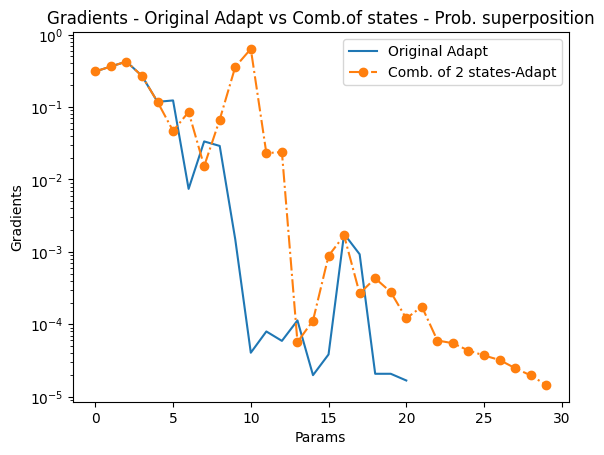

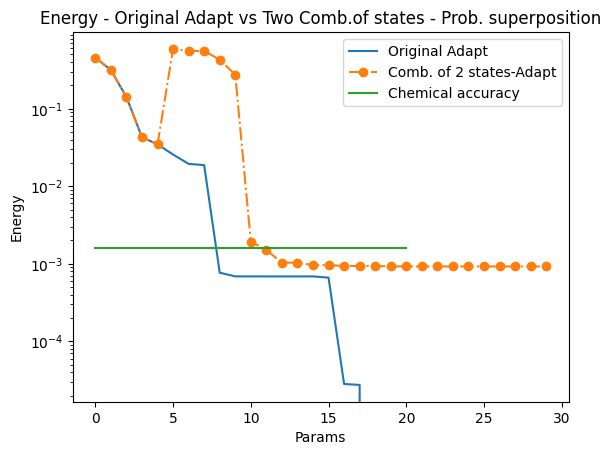

In [19]:
Error_Exact = np.array(E_Exact - FCI_Exact)
Error_Updated = np.array(energy_updated - FCI_Updated)
chem_accuracy = np.full(21, 1.59e-3)

import matplotlib.pyplot as plt
plt.plot(Distance_Exact, G_Exact, '-', label = 'Original Adapt')
plt.plot(Distance_updated, grad_updated, '-.o', label = 'Comb. of 2 states-Adapt')
plt.legend()
plt.yscale('log')
#plt.xlim(0,11)
plt.xlabel ('Params')
plt.ylabel('Gradients')
plt.title('Gradients - Original Adapt vs Comb.of states - Prob. superposition')
plt.show()

plt.plot(Distance_Exact, Error_Exact, '-', label = 'Original Adapt') 
plt.plot(Distance_updated, Error_Updated, '-.o', label = 'Comb. of 2 states-Adapt') 
plt.plot(Distance_Exact, chem_accuracy, '-', label = 'Chemical accuracy') 
plt.legend()
#plt.xlim(0,11)
plt.xlabel ('Params')
plt.ylabel('Energy')
plt.yscale('log')
plt.title('Energy - Original Adapt vs Two Comb.of states - Prob. superposition')
plt.show()

In [26]:
PHF = np.sqrt(0.285)
P2 = np.sqrt(0.213)

Px = PHF /(PHF + P2)
Py = P2 /(PHF + P2)

print('Px:', Px)
print('Py:', Py)

Px: 0.5363354600954722
Py: 0.4636645399045277
